Task 1: Load and Preprocess the SVHN Dataset

- Use the commands provided above to download and load the SVHN dataset.
- Preprocess the images (normalize and reshape).
- Display the shape of the training and test datasets.

In [17]:
!wget http://ufldl.stanford.edu/housenumbers/train_32x32.mat
!wget http://ufldl.stanford.edu/housenumbers/test_32x32.mat

--2024-10-11 00:22:24--  http://ufldl.stanford.edu/housenumbers/train_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182040794 (174M) [text/plain]
Saving to: ‘train_32x32.mat.2’

train_32x32.mat.2   100%[===================>] 173.61M  3.25MB/s    in 39s     

2024-10-11 00:23:03 (4.49 MB/s) - ‘train_32x32.mat.2’ saved [182040794/182040794]

--2024-10-11 00:23:03--  http://ufldl.stanford.edu/housenumbers/test_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64275384 (61M) [text/plain]
Saving to: ‘test_32x32.mat.2’

test_32x32.mat.2    100%[===================>]  61.30M  3.02MB/s    in 16s     

2024-10-11 00:23:19 (3.81 MB/s) - ‘test_32x32.mat.2’ saved [642

In [18]:
import numpy as np
from scipy.io import loadmat

# Load data
train_data = loadmat('train_32x32.mat')
test_data = loadmat('test_32x32.mat')

# Preprocess the data
x_train = np.transpose(train_data['X'], (3, 0, 1, 2)).astype('float32') / 255.0
y_train = train_data['y'].flatten()
x_test = np.transpose(test_data['X'], (3, 0, 1, 2)).astype('float32') / 255.0
y_test = test_data['y'].flatten()

# Display the shape of the datasets
print(f'Training data shape: {x_train.shape}')
print(f'Test data shape: {x_test.shape}')

Training data shape: (73257, 32, 32, 3)
Test data shape: (26032, 32, 32, 3)


Task 2: Build a Variational Autoencoder

- Define the encoder and decoder architecture for the VAE.
- Create the complete VAE model using the function: build_vae(latent_dim)
- Ensure it can take a specified latent dimension.

In [19]:
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import (
    layers,
    models,
    datasets,
    callbacks,
    losses,
    optimizers,
    metrics,
)

In [20]:
IMAGE_SIZE = 32
BATCH_SIZE = 100
VALIDATION_SPLIT = 0.2
EMBEDDING_DIM = 2
EPOCHS = 5
BETA = 500

In [21]:
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [22]:
#Encoder

# Define latent_dim
latent_dim = EMBEDDING_DIM  # Assuming you want to use the EMBEDDING_DIM value

encoder_input = layers.Input(shape=(32, 32, 3), name="encoder_input") # Changed input shape to (32, 32, 3)

x = layers.Conv2D(
    32, (3, 3), strides=2, activation="relu", padding="same"
)(encoder_input)
x = layers.Conv2D(
    64, (3, 3), strides=2, activation="relu", padding="same"
)(x)
x = layers.Conv2D(
    128, (3, 3), strides=2, activation="relu", padding="same"
)(x)
shape_before_flattening = K.int_shape(x)[1:]
x = layers.Flatten()(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x) # Use the defined latent_dim
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = models.Model(encoder_input, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ encoder_input             │ (None, 32, 32, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 16, 16, 32)     │            896 │ encoder_input[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 8, 8, 64)       │         18,496 │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 4, 4, 128)      │         73,856 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 2048)           │              0 │ conv2d_5[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_mean (Dense)            │ (None, 2)              │          4,098 │ flatten_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_log_var (Dense)         │ (None, 2)              │          4,098 │ flatten_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sampling_1 (Sampling)     │ (None, 2)              │              0 │ z_mean[0][0],          │
│                           │                        │                │ z_log_var[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 101,444 (396.27 KB)

 Trainable params: 101,444 (396.27 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
# Decoder

decoder_input = layers.Input(shape=(EMBEDDING_DIM,), name="decoder_input")
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(
    128, (3, 3), strides=2, activation="relu", padding="same"
)(x)
x = layers.Conv2DTranspose(
    64, (3, 3), strides=2, activation="relu", padding="same"
)(x)
x = layers.Conv2DTranspose(
    32, (3, 3), strides=2, activation="relu", padding="same"
)(x)

decoder_output = layers.Conv2D(
    3,
    (3, 3),
    strides=1,
    activation="sigmoid",
    padding="same",
    name="decoder_output",
)(x)

decoder = models.Model(decoder_input, decoder_output)
decoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)           │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2048)                │           6,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_3 (Conv2DTranspose) │ (None, 8, 8, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_4 (Conv2DTranspose) │ (None, 16, 16, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_5 (Conv2DTranspose) │ (None, 32, 32, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_output (Conv2D)              │ (None, 32, 32, 3)           │             867 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 246,851 (964.26 KB)

 Trainable params: 246,851 (964.26 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:
def build_vae(latent_dim):
    vae = VAE(encoder, decoder)
    return vae

class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstruction = self.decoder(z)
        return z_mean, z_log_var, reconstruction

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]

        with tf.GradientTape() as tape:
            z_mean, z_log_var, reconstruction = self(data)
            reconstruction_loss = tf.reduce_mean(BETA * losses.binary_crossentropy(data, reconstruction, axis=(1, 2, 3)))
            kl_loss = tf.reduce_mean(tf.reduce_sum(-0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)), axis=1))
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        if isinstance(data, tuple):
            data = data[0]

        z_mean, z_log_var, reconstruction = self(data)
        reconstruction_loss = tf.reduce_mean(BETA * losses.binary_crossentropy(data, reconstruction, axis=(1, 2, 3)))
        kl_loss = tf.reduce_mean(tf.reduce_sum(-0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)), axis=1))
        total_loss = reconstruction_loss + kl_loss

        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

vae_model = build_vae(EMBEDDING_DIM)
vae_model.compile(optimizer='adam')

Task 3: Train the VAE with Different Latent Dimensions

- Train the VAE with latent dimensions of 2, 5, and 10. Use the following for-loop in main:
- Monitor the training process and evaluate the model's performance.

In [25]:
optimizer = optimizers.Adam(learning_rate=0.0005)
vae.compile(optimizer=optimizer)

In [26]:
latent_dims = [2, 5, 10]
for dim in latent_dims:
    print(f'Training VAE with latent dimension: {dim}')
    vae = build_vae(latent_dim=dim)
    vae.compile(optimizer='adam', loss=losses.binary_crossentropy)
    vae.fit(x_train, x_train, epochs=50, batch_size=128, validation_data=(x_test, x_test))

Training VAE with latent dimension: 2
Epoch 1/50
573/573 ━━━━━━━━━━━━━━━━━━━━ 23s 24ms/step - kl_loss: 1.8189 - reconstruction_loss: 329.5310 - total_loss: 331.3500 - val_kl_loss: 2.9159 - val_loss: 316.0944 - val_reconstruction_loss: 313.1785
Epoch 2/50
573/573 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - kl_loss: 2.7825 - reconstruction_loss: 318.4914 - total_loss: 321.2738 - val_kl_loss: 3.0144 - val_loss: 316.3359 - val_reconstruction_loss: 313.3215
Epoch 3/50
573/573 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - kl_loss: 2.8095 - reconstruction_loss: 318.0565 - total_loss: 320.8660 - val_kl_loss: 2.9930 - val_loss: 316.3001 - val_reconstruction_loss: 313.3071
Epoch 4/50
573/573 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - kl_loss: 2.8139 - reconstruction_loss: 318.0934 - total_loss: 320.9073 - val_kl_loss: 3.1266 - val_loss: 316.6104 - val_reconstruction_loss: 313.4838
Epoch 5/50
573/573 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - kl_loss: 2.8299 - reconstruction_loss: 318.1665 - total_loss: 320.9965 - val_kl_loss:

- We have a low kl_loss which is good
- we also have a high reconstruction loss and consideering how fast our model trained id like to test outside experiments with higher epochs
- our total and validation loss are also high but close which displays good generalization, also will rerun with double the epochs maybe

Create visualizations of original and reconstructed images for the largest latent dimension.

In [27]:
n_to_predict = 5000
example_images = x_test[:n_to_predict]
example_labels = y_test[:n_to_predict]

In [28]:
z_mean, z_log_var, reconstructions = vae.predict(example_images)
print("Example real clothing items")
display(example_images)
print("Reconstructions")
display(reconstructions)

157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step
Example real clothing items


array([[[[0.14901961, 0.40392157, 0.23529412],
         [0.15294118, 0.40784314, 0.23921569],
         [0.15294118, 0.40784314, 0.24313726],
         ...,
         [0.16078432, 0.4       , 0.23921569],
         [0.16470589, 0.40392157, 0.24313726],
         [0.15294118, 0.38039216, 0.22352941]],

        [[0.15294118, 0.40784314, 0.23921569],
         [0.15294118, 0.40784314, 0.23921569],
         [0.15294118, 0.40784314, 0.24313726],
         ...,
         [0.16078432, 0.4       , 0.23921569],
         [0.16862746, 0.39607844, 0.24705882],
         [0.15294118, 0.38039216, 0.22352941]],

        [[0.14901961, 0.4117647 , 0.24313726],
         [0.14509805, 0.40784314, 0.23921569],
         [0.15294118, 0.41568628, 0.24705882],
         ...,
         [0.16862746, 0.39607844, 0.24705882],
         [0.16862746, 0.39215687, 0.2509804 ],
         [0.15294118, 0.38039216, 0.23137255]],

        ...,

        [[0.20392157, 0.46666667, 0.30588236],
         [0.20784314, 0.47058824, 0.30980393]

Reconstructions


array([[[[0.32358736, 0.28896537, 0.24845146],
         [0.32946855, 0.29067793, 0.24465798],
         [0.32456586, 0.2911781 , 0.25041077],
         ...,
         [0.3247875 , 0.29115218, 0.2540534 ],
         [0.3246152 , 0.2881081 , 0.2506927 ],
         [0.3209582 , 0.28778154, 0.253743  ]],

        [[0.3249828 , 0.28432345, 0.2391503 ],
         [0.3234515 , 0.28420123, 0.24000701],
         [0.3173768 , 0.2809618 , 0.24237254],
         ...,
         [0.31716454, 0.28412953, 0.24949159],
         [0.31699884, 0.28222412, 0.24896154],
         [0.31477422, 0.28046167, 0.24857774]],

        [[0.3139377 , 0.27510536, 0.23892647],
         [0.3077156 , 0.27236918, 0.23610461],
         [0.30959597, 0.2759875 , 0.23941518],
         ...,
         [0.3097133 , 0.2835528 , 0.2499264 ],
         [0.30708906, 0.27956536, 0.2460306 ],
         [0.3078922 , 0.28028566, 0.24853191]],

        ...,

        [[0.30428082, 0.27430496, 0.24061957],
         [0.30535448, 0.27570838, 0.24066684]

In [29]:
z_mean, z_var, z = encoder.predict(example_images)

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [30]:
print(z[:10])

[[-0.1058957   1.3981469 ]
 [-0.26174045 -1.3069519 ]
 [ 0.32317162 -0.707131  ]
 [ 0.58214104 -1.0210948 ]
 [ 0.15359889 -1.1270343 ]
 [-0.32995698  0.2160545 ]
 [ 0.833211    2.557599  ]
 [ 1.9713975   1.1512738 ]
 [-0.6650099  -1.170371  ]
 [ 0.25429922 -0.6872583 ]]


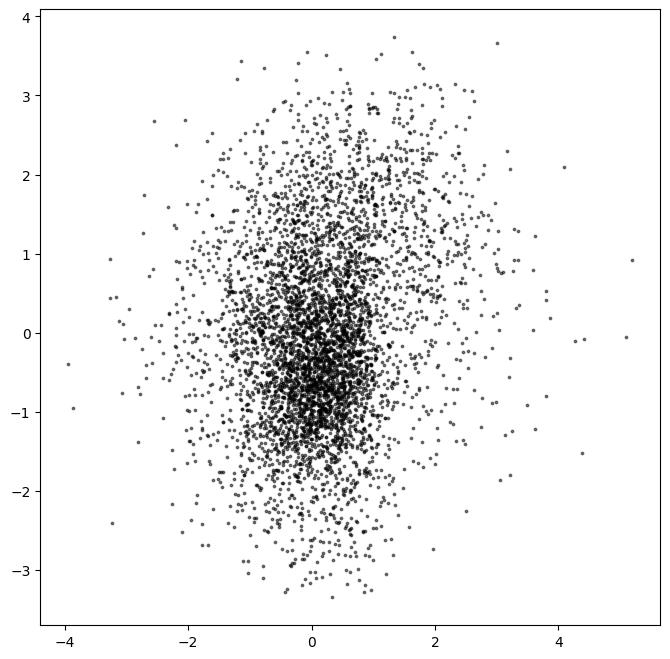

In [31]:
figsize = 8

plt.figure(figsize=(figsize, figsize))
plt.scatter(z[:, 0], z[:, 1], c="black", alpha=0.5, s=3)
plt.show()

In [32]:
grid_width, grid_height = (6, 3)
z_sample = np.random.normal(size=(grid_width * grid_height, 2))

In [33]:
reconstructions = decoder.predict(z_sample)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [35]:
from scipy.stats import norm

In [36]:
p = norm.cdf(z)
p_sample = norm.cdf(z_sample)

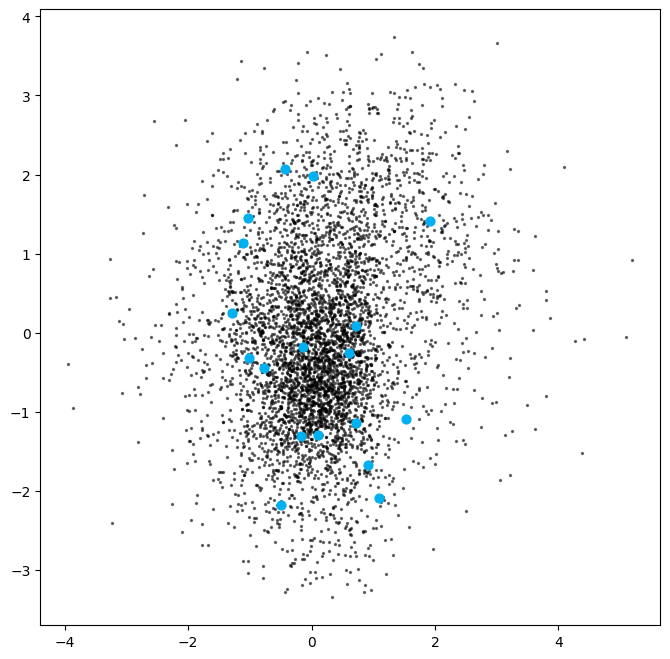

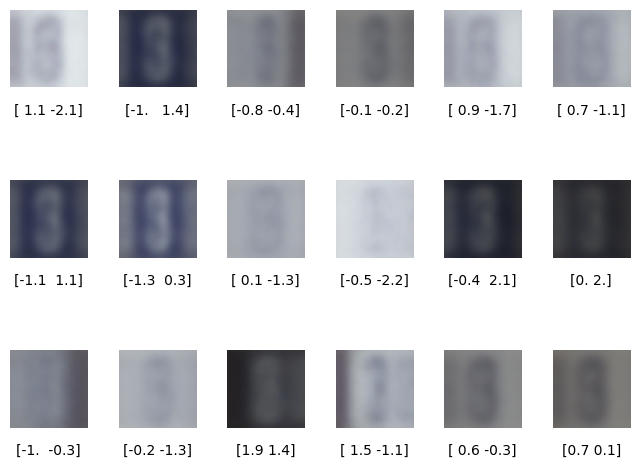

In [37]:
figsize = 8
plt.figure(figsize=(figsize, figsize))

# ... the original embeddings ...
plt.scatter(z[:, 0], z[:, 1], c="black", alpha=0.5, s=2)

# ... and the newly generated points in the latent space
plt.scatter(z_sample[:, 0], z_sample[:, 1], c="#00B0F0", alpha=1, s=40)
plt.show()

# Add underneath a grid of the decoded images
fig = plt.figure(figsize=(figsize, grid_height * 2))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.text(
        0.5,
        -0.35,
        str(np.round(z_sample[i, :], 1)),
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.imshow(reconstructions[i, :, :], cmap="Greys")